In [1]:
object = torch.load( 'VGG_n01443537.t7' )

In [2]:
Plot = require 'itorch.Plot'

shared_neurons = {}
all_neurons_shared_prob = torch.Tensor(512)
local topN = 197
shared_prob_idx = {}
for i=1, 10 do
    shared_prob_idx[i] = {}
end

point_index = torch.Tensor(512)
for i=1, 512 do
    point_index[i] = i
end


for neuron_idx=1,512 do
    local pick = true
    local total_shared_imgs = 0
    local total_imgs = 0
    for j in pairs(object) do
        local find_index = false
        --print(object[j].file_name)
        --print(object[j].topN_index)
        for k=1,topN do
            if neuron_idx == object[j].topN_index[k].idx then
                find_index = true
                total_shared_imgs = total_shared_imgs + 1
            end
        end
    
        if find_index == false then
            pick = false
        end
        
        total_imgs = total_imgs + 1
    end
    
    --print('idx :'.. neuron_idx .. ' is done!' )
    
    all_neurons_shared_prob[neuron_idx] = total_shared_imgs/total_imgs
    --print( 'neuron: '..neuron_idx..' prob: '.. math.floor(total_shared_imgs/total_imgs*10 ) )
    if math.floor(total_shared_imgs/total_imgs*10) ~= 0 then
        local prob_idx = math.floor(total_shared_imgs/total_imgs* 10)
        table.insert( shared_prob_idx[prob_idx], neuron_idx )
    else
        table.insert( shared_prob_idx[1], neuron_idx )
    end
        
    if pick == true then
        print( neuron_idx .. ' is shared neuron from TopN' )
        table.insert(shared_neurons, neuron_idx)
    end
end

-- for i=1,256 do
--     print( i..'  '.. all_neurons_shared_prob:sort(true)[i])
-- end
--plot = Plot():line( point_index, all_neurons_shared_prob:sort(true),'red','Classification Curve'):legend(true):title('Insertion'):draw()

--print( shared_prob[10])



114 is shared neuron from TopN	


156 is shared neuron from TopN	


442 is shared neuron from TopN	


In [6]:
require 'loadcaffe'
require 'cudnn'
require 'inn'
require 'image'
require 'dcnn'

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 
print '==> Loading network'

prototxt_name = '/usr/local/data/CaffeZoo/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers_deploy.prototxt'
binary_name = '/usr/local/data/CaffeZoo/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers.caffemodel'

net = loadcaffe.load(prototxt_name, binary_name, 'cudnn')

net:cuda()
-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()
net:remove(40)

print '==> Loading image and imagenet mean'
image_name = 'Goldfish3.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)


-- Replace pooling by dual pooling
unpooling_layers = dcnn:ReplaceDualPoolingModule(net)

print '==> Forward'
-- Forward before setup dcnn
net:forward(I:cuda()):view(-1):float():sort(true)

==> Loading network	


Successfully loaded /usr/local/data/CaffeZoo/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3


conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


==> Loading image and imagenet mean	


==> Preprocessing	


==> Forward	


In [16]:
prob_lower_bound = 8
shared_neurons={}


neuron_num = 0

for i=10,prob_lower_bound, -1 do
    for j in pairs(shared_prob_idx[i]) do
        neuron_num = neuron_num +1
        shared_neurons[neuron_num] = shared_prob_idx[i][j]  
    end
end
    
neurons_idx = torch.IntTensor(neuron_num)
rest_of_neurons = torch.IntTensor(512-neuron_num):zero()
rest_idx = torch.Tensor(512):zero()

for i=1,neuron_num do
    neurons_idx[i] = shared_neurons[i]
    rest_idx[neurons_idx[i]] = 1
end

local counter = 1
for i=1, 512 do
    if rest_idx[i] == 0 then
        rest_of_neurons[counter]=i
        counter = counter + 1
    end
end

print(neurons_idx:size(1))


71	


cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(512 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 512, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(128 -> 256, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(128 -> 128, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(64 -> 128, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(64 -> 64, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(3 -> 64, 3x3, 1,1, 1,1)	
deconv layer has been built !	


==> Time elapsed: 0.81689500808716 seconds	


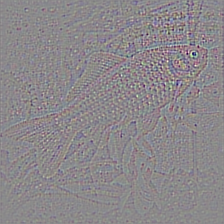

In [17]:
deconvNet_VGG = dcnn:CreateDeconvNet( net, unpooling_layers, I, 29, neurons_idx )

deconv_timer = torch.Timer()
vis_c16 = deconvNet_VGG:forward(net:get(29).output)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c16)